# US Freight Industry

This is the final project for the Data Science course by Cambridge ICU, delivered by Flatiron School. In this project, I will use the dataset, Freight Analysis Framework Version 5 (FAF5).

The [Freight Analysis Framework (FAF)](https://faf.ornl.gov/faf5/), produced through a partnership between BTS and FHWA, integrates data from various sources to create a comprehensive picture of freight movement among states and major metropolitan areas by all modes of transportation. The 2017 Commodity Flow Survey (CFS) and international trade data from the Census Bureau serve as the backbone of FAF and are integrated with ancillary data sources that capture goods movement in agriculture, resource extraction, utility, construction, retail, services, and other sectors.

## Import Libraries

I'll import the libraries I need for data cleaning, manipulation and visualization.

In [454]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from itertools import chain

## Import Dataset

I'll import the main dataset and take a look at the columns.

In [234]:
regions_df = pd.read_csv('FAF5.3.csv', dtype = {'dms_orig': str, 'dms_dest': str})
regions_df.columns

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'tons_2018', 'tons_2019', 'tons_2020', 'tons_2022', 'tons_2023',
       'tons_2025', 'tons_2030', 'tons_2035', 'tons_2040', 'tons_2045',
       'tons_2050', 'value_2017', 'value_2018', 'value_2019', 'value_2020',
       'value_2022', 'value_2023', 'value_2025', 'value_2030', 'value_2035',
       'value_2040', 'value_2045', 'value_2050', 'current_value_2018',
       'current_value_2019', 'tmiles_2017', 'tmiles_2018', 'tmiles_2019',
       'tmiles_2020', 'tmiles_2022', 'tmiles_2023', 'tmiles_2025',
       'tmiles_2030', 'tmiles_2035', 'tmiles_2040', 'tmiles_2045',
       'tmiles_2050'],
      dtype='object')

From the main dataframe, we can separate imports/exports using fr_dest and fr_orig. `fr_dest` stands for foreign region of shipment destination. `fr_orig` stands for foreign region of shipment origin.

In [235]:
# domestic destination
dom_dest_df = regions_df.loc[pd.isnull(regions_df['fr_dest'])]

# domestic origin
dom_origin_df = regions_df.loc[pd.isnull(regions_df['fr_orig'])]
dom_origin_df

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2019,tmiles_2020,tmiles_2022,tmiles_2023,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050
0,NaN,011,011,NaN,NaN,1,NaN,1,1,1,...,3.351765,3.398871,3.614785,3.718716,4.364371,5.327137,6.342501,7.763605,9.571647,11.343818
1,NaN,011,019,NaN,NaN,1,NaN,1,1,2,...,50.646235,51.702439,54.030117,55.009694,62.052489,72.493059,82.113979,96.869428,116.602924,134.683927
2,NaN,011,129,NaN,NaN,1,NaN,1,1,3,...,0.468714,0.476138,0.483170,0.481371,0.486727,0.533539,0.564126,0.638719,0.750361,0.844720
3,NaN,011,131,NaN,NaN,1,NaN,1,1,2,...,2.267241,2.372436,2.359789,2.352784,2.549854,3.018065,3.155784,3.394250,3.850035,4.178881
4,NaN,011,139,NaN,NaN,1,NaN,1,1,2,...,1.327792,1.421785,1.412938,1.412791,1.554450,1.863748,1.969298,2.141527,2.456208,2.683008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398858,NaN,559,061,808.0,NaN,1,3.0,43,3,8,...,0.000000,0.244204,0.267250,0.275731,0.294570,0.345673,0.396910,0.458420,0.532266,0.620986
2398859,NaN,559,171,808.0,NaN,1,4.0,43,3,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2398860,NaN,559,279,808.0,NaN,7,7.0,43,3,3,...,0.000000,1.722202,1.783264,1.827262,1.936252,2.203291,2.484983,2.819591,3.217100,3.689749
2398861,NaN,559,512,808.0,NaN,1,3.0,43,3,6,...,0.000000,0.000426,0.000512,0.000535,0.000579,0.000698,0.000819,0.000964,0.001140,0.001352


## Setup Variables and Dictionaries

The list of commodities is obtained from the FAF5 metadata file.

In [236]:
com_df = pd.read_csv('FAF5_commodities.csv')
com_list = commodities_df['Description']

com_dict = {}
for i in range(1, len(com_list)+1):
    com_dict[i] = com_list[i-1]

com_dict[99] = 'Commodity Unknown'
com_dict[43] = 'Mixed freight'
# com_dict # Uncomment line to view the list of commodities / com_list

In [339]:
# dictionary of foreign trading partners
fr_dict = {801: "Canada", 802: "Mexico", 803: "Rest of Americas", 804: "Europe", 805: "Africa",
           806: "SW & Central Asia", 807: "Eastern Asia", 808: "SE Asia & Oceania",
           'total': "Total"}

# transportation mode dictionary and list
# mode_dict = {1: "Truck", 2: "Rail", 3: "Water", 4: "Air", 5: "Multimode and mail", 6: "Pipeline",
#              7: "Other/unknown", 8: "No domestic mode"}

# List of modes
mode_list = ["Truck", "Rail", "Water", "Air", "Multimode and mail", "Pipeline", "Other/unknown"]

# List of years
years = ['2017', '2018', '2019','2020','2022', '2023', '2025', '2030', '2035', '2040', '2045', '2050']

## Production and Consumption of Commodities

To get an yearly chart of commodities by productio and consumption, we will create two dataframes based on commodities moving towards origin and destination.

In [238]:
goodsAndYearsCols = ['sctg2','value_2017', 'value_2018', 'value_2019', 'value_2020', 'value_2022', 'value_2023',
 'value_2025', 'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050']

# origin dataframe
dom_origin_comm_df = dom_origin_df[goodsAndYearsCols].groupby('sctg2', as_index = False).sum()
dom_origin_comm_df.columns = ['sctg2'] + years
dom_origin_comm_df.loc['total'] = dom_origin_comm_df.sum()

# destination dataframe
dom_dest_comm_df = dom_dest_df[goodsAndYearsCols].groupby('sctg2', as_index = False).sum()
dom_dest_comm_df.columns = ['sctg2'] + years
dom_dest_comm_df.loc['total'] = dom_dest_comm_df.sum()

In [239]:
# list of top 10 commodities by consumption (2017 and 2050)
# top_10_dest_2017 = dom_dest_comm_df[['sctg2','2017','2050']].sort_values('2017', axis = 0, ascending = False)

top_10_dest_2017 = dom_dest_comm_df[['sctg2','2017','2050']].sort_values('2017', axis = 0, ascending = False).head(11)
top_10_dest_2017.drop('total', inplace = True)

top_10_dest_2050 = dom_dest_comm_df[['sctg2','2017','2050']].sort_values('2050', axis = 0, ascending = False).head(11)
top_10_dest_2050.drop('total', inplace = True)

top_2017_dest = top_10_dest_2017['sctg2'].values.flatten().tolist()
top_2050_dest = top_10_dest_2050['sctg2'].values.flatten().tolist()
top_dest_list = [x for x in top_2017_dest or top_2050_dest]

top_dest_2017_2050 = dom_dest_comm_df.loc[dom_dest_comm_df['sctg2'].isin(top_dest_list), 
                                          ['sctg2']+years]
top_dest_2017_2050.reset_index(inplace = True, drop = True)
top_dest_2017_2050['Commodity'] = top_dest_2017_2050['sctg2'].apply(lambda x: com_dict[x])

In [240]:
# list of top 10 commodities by production (2012 and 2045)
top_10_origin_2017 = dom_origin_comm_df[['sctg2','2017','2050']].sort_values('2017', axis = 0, ascending = False).head(11)
top_10_origin_2017.drop('total', inplace = True)

top_10_origin_2050 = dom_origin_comm_df[['sctg2','2017','2050']].sort_values('2050', axis = 0, ascending = False).head(11)
top_10_origin_2050.drop('total', inplace = True)

top_2017_origin = top_10_origin_2017['sctg2'].values.flatten().tolist()
top_2050_origin = top_10_origin_2050['sctg2'].values.flatten().tolist()
top_origin_list = [x for x in top_2017_origin or top_2050_origin]

top_origin_2017_2050 = dom_origin_comm_df.loc[dom_origin_comm_df['sctg2'].isin(top_origin_list),  ['sctg2'] + years]
top_origin_2017_2050.reset_index(inplace = True, drop = True)
top_origin_2017_2050['Commodity'] = top_origin_2017_2050['sctg2'].apply(lambda x: com_dict[x])

In [336]:


def plotCommodities(df, years, gridSize, title, xlabels, ylabels):
    fig, ax = plt.subplots(nrows=gridSize[0], ncols=gridSize[1], figsize=(15,15))
    fig.set_figheight(25)
    fig.set_figwidth(25)
    
    currentRow = 0
    
    for row in ax:
        for col in row:
            if(currentRow < df.shape[0]):
                col.plot(years, df.iloc[currentRow, 1:13])
                col.set_title(df.iloc[currentRow, 13])
                col.set(xlabel=xlabels, ylabel=ylabels)
                currentRow = currentRow + 1
    
    
    plt.suptitle(title,fontsize=20)

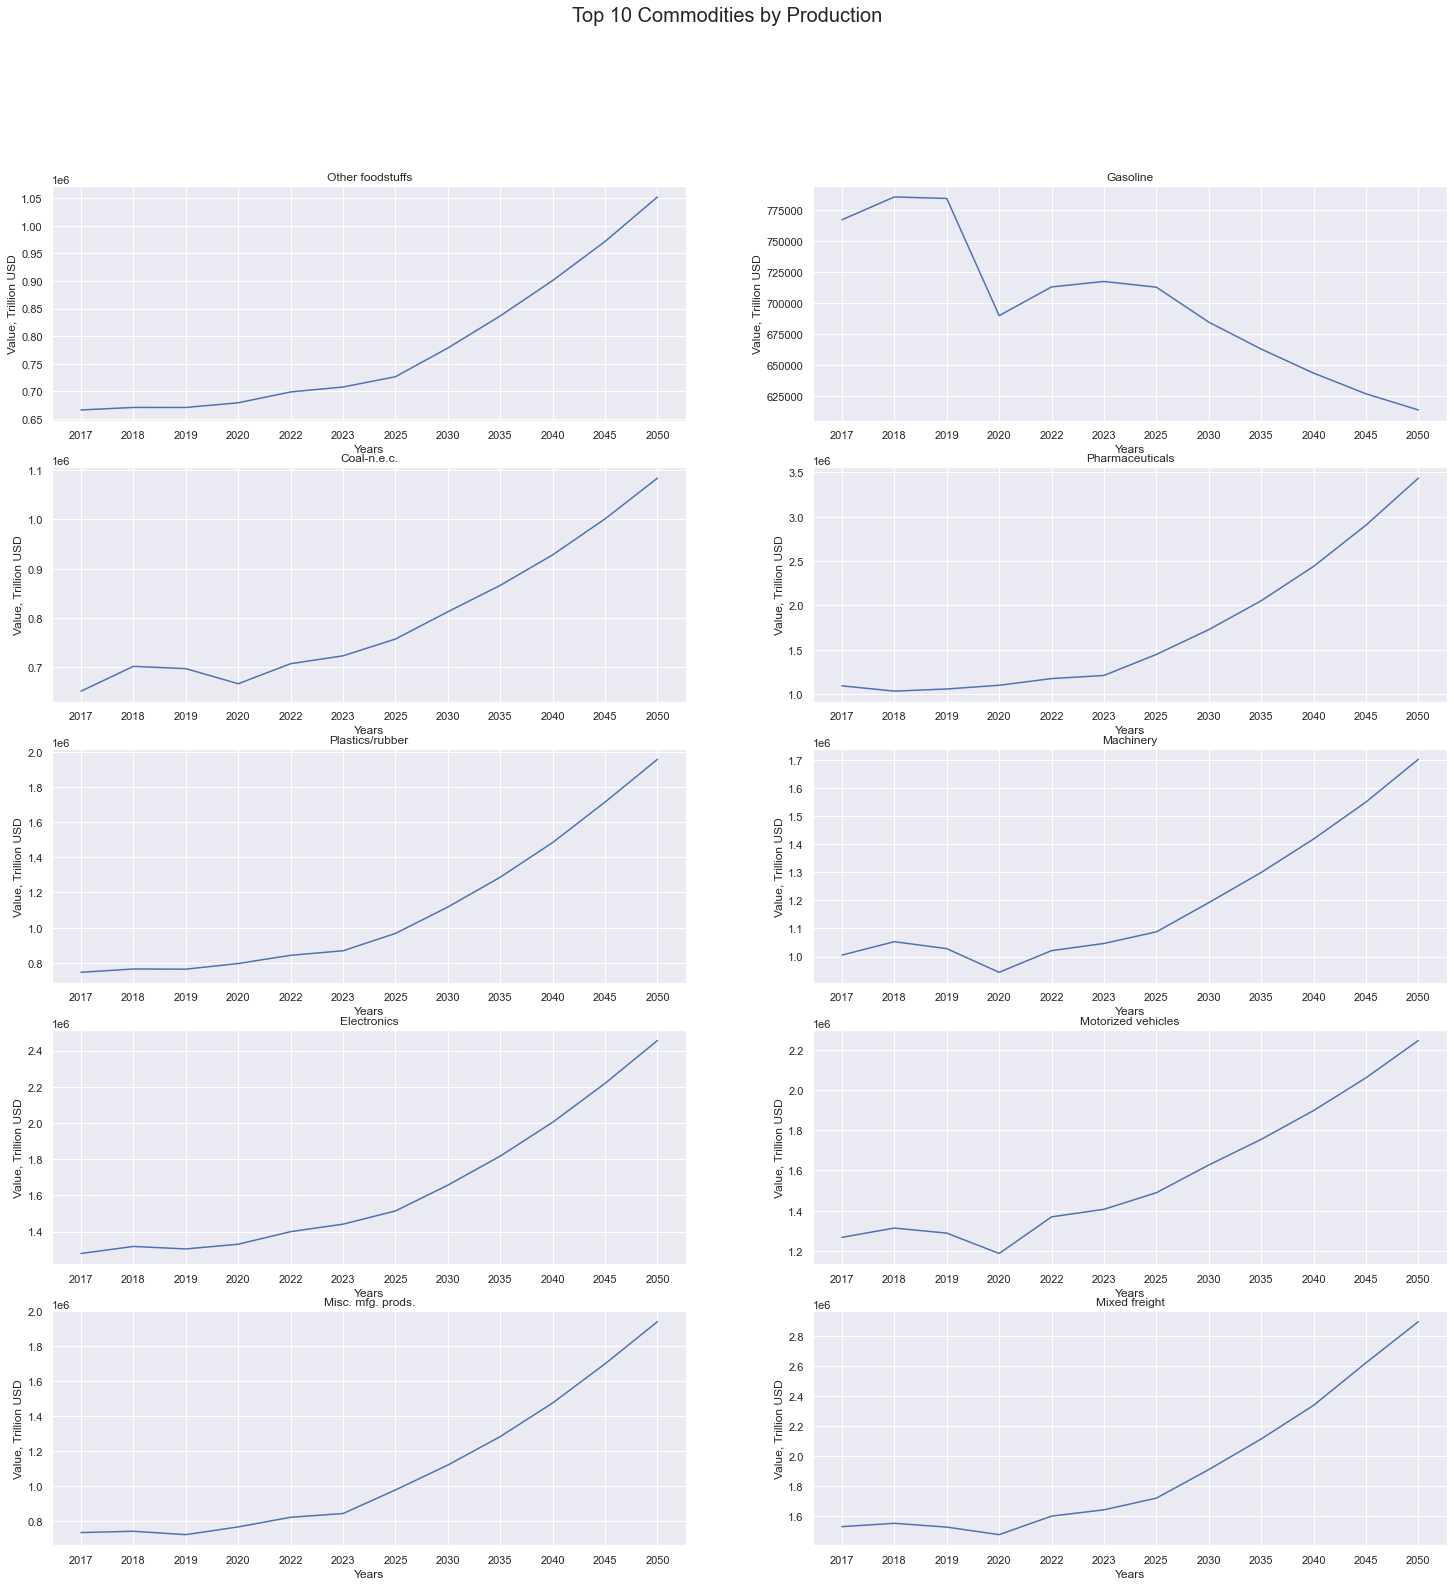

In [337]:
plotCommodities(top_origin_2017_2050, years, (5, 2), 'Top 10 Commodities by Production', "Years", "Value, Trillion USD")

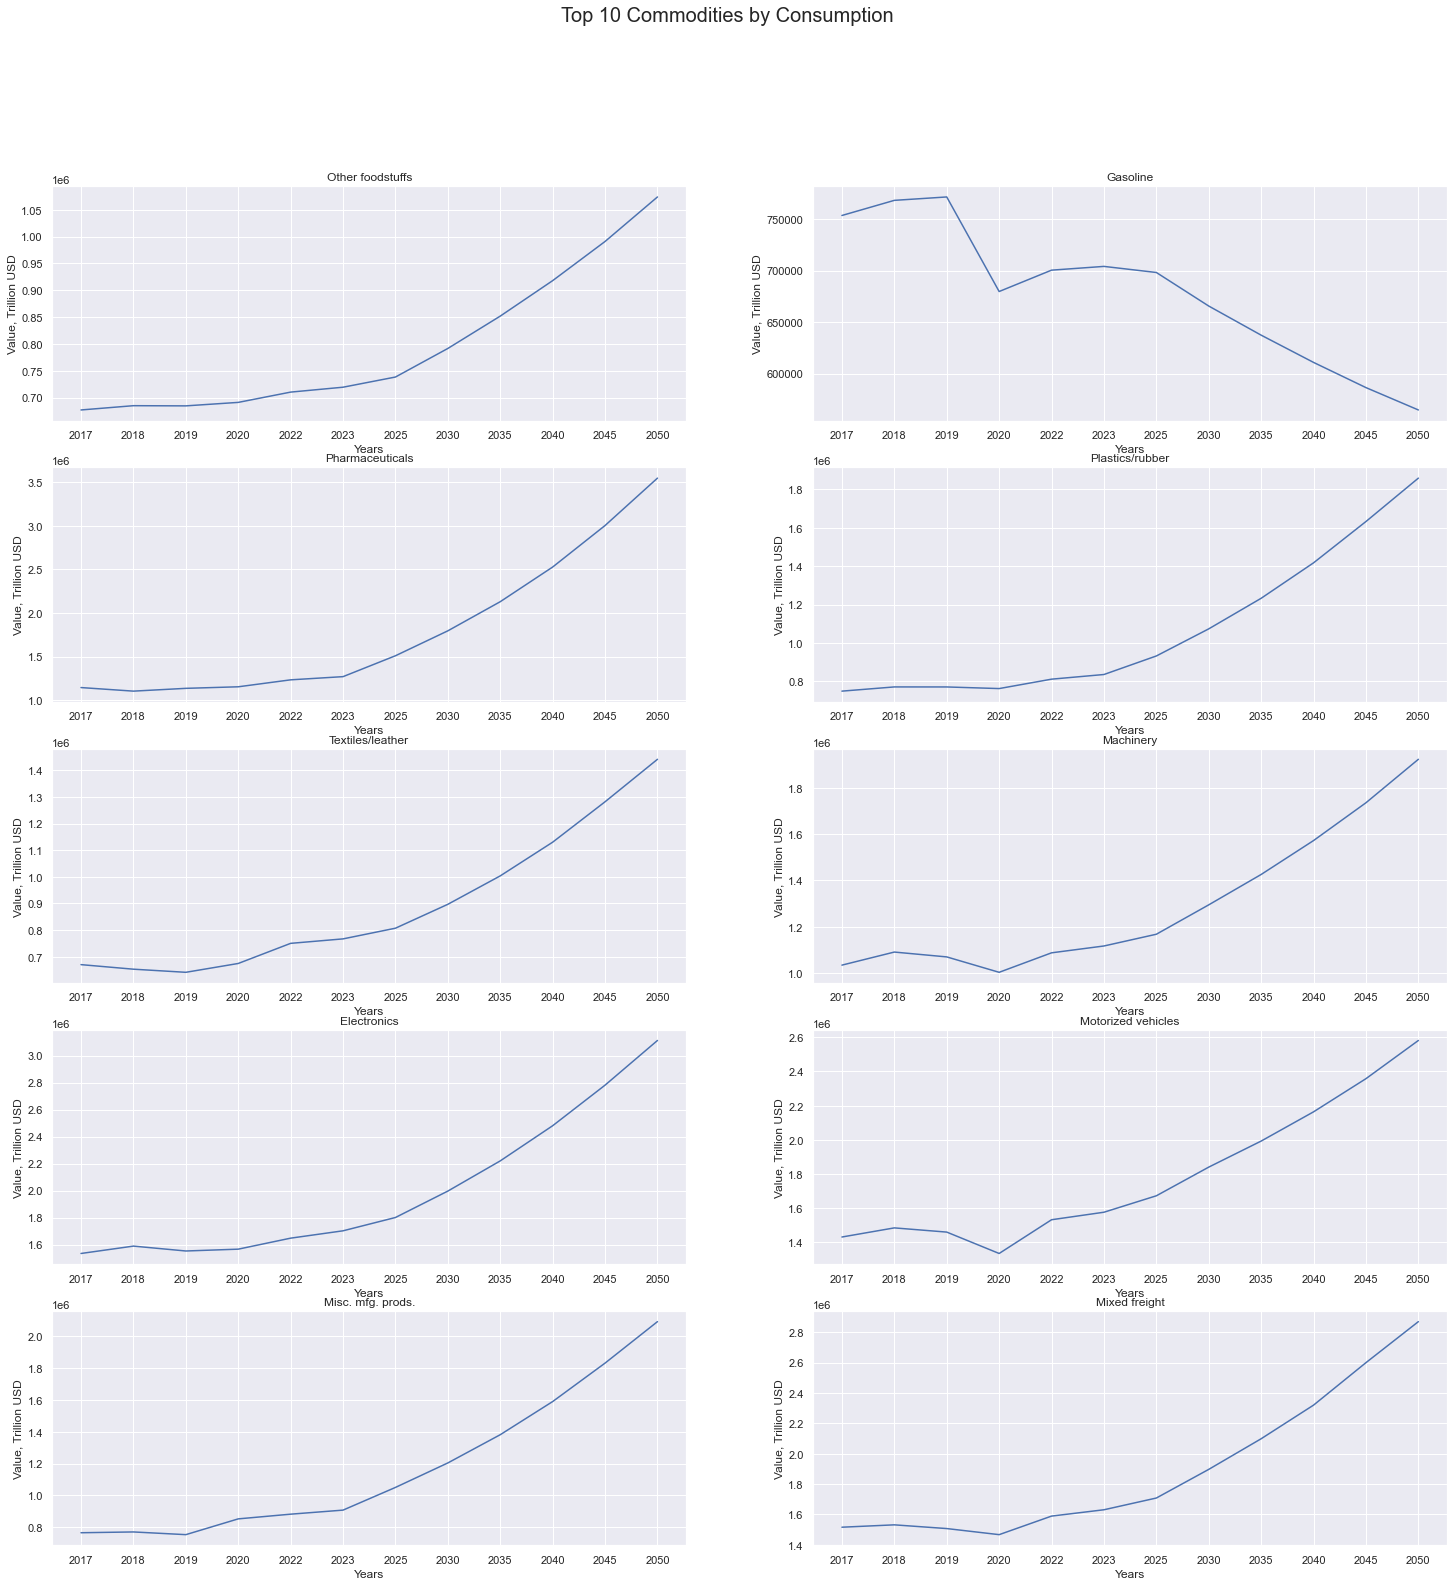

In [338]:
plotCommodities(top_dest_2017_2050, years, (5, 2), 'Top 10 Commodities by Consumption', "Years", "Value, Trillion USD")

In [341]:
# For domestic, we use dms_mode, and for international fr_inmode and fr_outmode are used

domesticYearsCols = ['dms_mode','value_2017', 'value_2018', 'value_2019', 'value_2020', 'value_2022', 'value_2023',
 'value_2025', 'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050']

domestic_mode_df = regions_df[domesticYearsCols].groupby('dms_mode', as_index = False).sum()
domestic_mode_df.columns = ['dms_mode'] + years

# 8 is not domestic transportation mode so excluding it
domestic_mode_df = domestic_mode_df.loc[domestic_mode_df['dms_mode']!=8,]

domestic_mode_df[years] = domestic_mode_df[years].div(domestic_mode_df[years].sum(axis=0), axis=1).multiply(100)

In [344]:
# foreign fraight type (both import and export)
# domestic origin for export by value 2012-2045

frDestYearsCols = ['fr_outmode','value_2017', 'value_2018', 'value_2019', 'value_2020', 'value_2022', 'value_2023',
 'value_2025', 'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050']
frOrigYearsCols = ['fr_inmode','value_2017', 'value_2018', 'value_2019', 'value_2020', 'value_2022', 'value_2023',
 'value_2025', 'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050']

for_dest_df = regions_df.loc[pd.notnull(regions_df['fr_dest'])]
for_orig_df = regions_df.loc[pd.notnull(regions_df['fr_orig'])]

for_outmode_df = for_dest_df[frDestYearsCols].groupby('fr_outmode', as_index = True).sum()
for_inmode_df = for_orig_df[frOrigYearsCols].groupby('fr_inmode', as_index = True).sum()

for_mode_df = for_outmode_df.add(for_inmode_df) # add

for_mode_df.reset_index(inplace = True)
for_mode_df.columns = ['for_mode'] + years

for_mode_df[years] = for_mode_df[years].div(for_mode_df[years].sum(axis=0), axis=1).multiply(100)

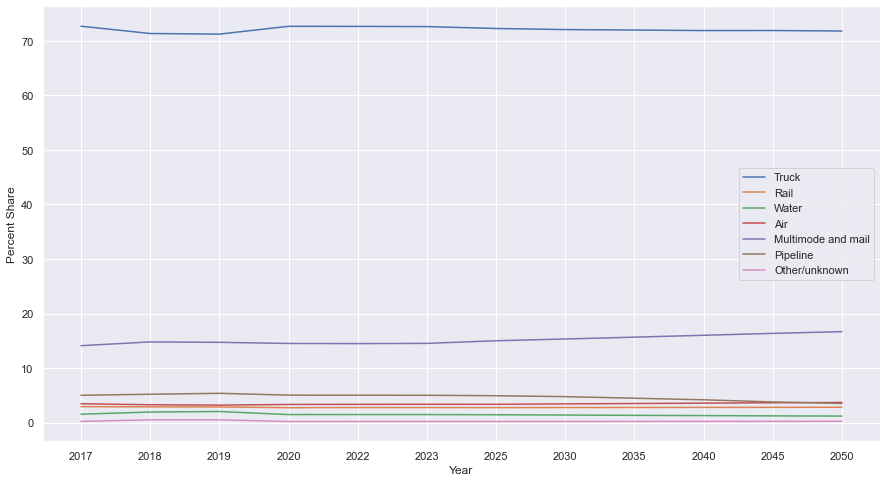

In [363]:
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

currMode = 0

for name in mode_list:
    ax.plot(domestic_mode_df.iloc[:, 1:13].columns, domestic_mode_df.iloc[currMode, 1:13],label=name)
    currMode = currMode + 1

ax.set_xlabel("Year")
ax.set_ylabel("Percent Share")
ax.legend(loc='best')

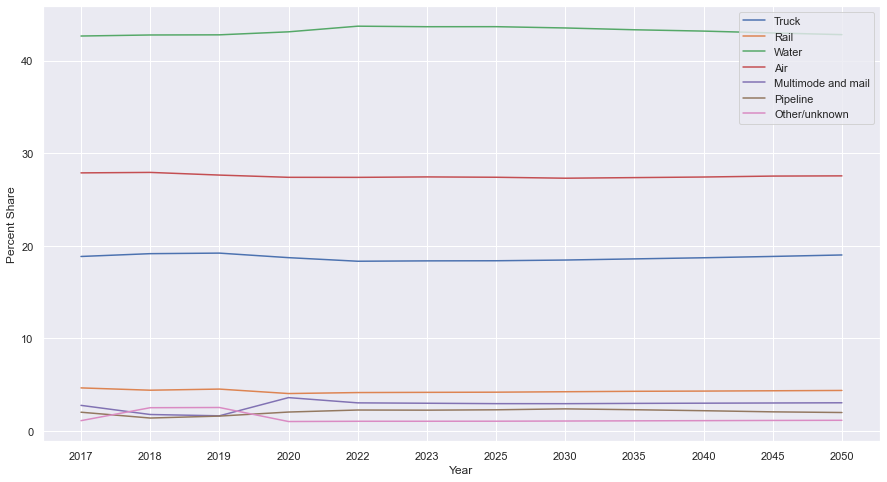

In [364]:
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

currMode = 0

for name in mode_list:
    ax.plot(for_mode_df.iloc[:, 1:13].columns, for_mode_df.iloc[currMode, 1:13],label=name)
    currMode = currMode + 1

ax.set_xlabel("Year")
ax.set_ylabel("Percent Share")
ax.legend(loc='best')

In [602]:
domestic_mode_df

,dms_mode,2017,2018,2019,2020,2022,2023,2025,2030,2035,2040,2045,2050
0,1,72.666113,71.324609,71.213334,72.644681,72.629273,72.591459,72.246724,72.045003,71.957974,71.865346,71.875156,71.779908
1,2,2.937412,2.899055,2.887365,2.746185,2.773636,2.773742,2.757668,2.777321,2.788968,2.799778,2.813104,2.831265
2,3,1.553560,1.951895,2.045615,1.489531,1.494153,1.485212,1.455544,1.400764,1.344236,1.300977,1.248027,1.211637
3,4,3.469808,3.286833,3.219719,3.339827,3.359182,3.372767,3.366430,3.444486,3.514764,3.582353,3.649877,3.709378
4,5,14.111024,14.800967,14.725776,14.519140,14.493988,14.532958,15.013881,15.335129,15.677345,16.017049,16.365158,16.687799
5,6,5.023016,5.211005,5.380464,5.050085,5.029648,5.023024,4.940903,4.771956,4.485478,4.196378,3.802823,3.526962
6,7,0.239068,0.525637,0.527727,0.210550,0.220120,0.220838,0.218850,0.225340,0.231235,0.238119,0.245854,0.253050


In [599]:

currYears = ['2017','2018','2019','2020','2022','2023','2025','2030','2035','2040','2045','2050']
dfm = []
for year in currYears:
    dfn1 = for_mode_df[['for_mode', year]]
    dfn1.rename(columns={year:'Percent Share'}, inplace=True)
    dfn1['Year'] = year
    dfm.append(dfn1)
dfn = pd.concat(dfm)


def label_mode(row):
    mymode = mode_list[int(row['for_mode']) - 1]
    row['Mode'] = mymode
    return row

dfn = dfn.apply(label_mode, axis=1)

fig = px.bar(dfn, x='Mode', y='Percent Share', color='Mode',
                     animation_frame="Year", animation_group="Mode")
fig.show()


/Users/tashfeen/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-599-f56bddf75ac8>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [603]:

currYears = ['2017','2018','2019','2020','2022','2023','2025','2030','2035','2040','2045','2050']
dfm = []
for year in currYears:
    dfn1 = domestic_mode_df[['dms_mode', year]]
    dfn1.rename(columns={year:'Percent Share'}, inplace=True)
    dfn1['Year'] = year
    dfm.append(dfn1)
dfn = pd.concat(dfm)


def label_dmode(row):
    mymode = mode_list[int(row['dms_mode']) - 1]
    row['Mode'] = mymode
    return row

dfn = dfn.apply(label_dmode, axis=1)

fig = px.bar(dfn, x='Mode', y='Percent Share', color='Mode',
                     animation_frame="Year", animation_group="Mode")
fig.show()


/Users/tashfeen/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-603-c5d1b0cdc4cc>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [376]:
adf = pd.read_csv('air_cargo.csv')
adf.columns

Index(['Airport Name', 'Year', 'City', 'Airport ID', 'Measure', 'Value'], dtype='object')

In [377]:
adf.shape

(1586, 6)

In [379]:
len(adf['Airport Name'].unique()) # data from 145 unique airports

145

In [382]:
adf.head()

,Airport Name,Year,City,Airport ID,Measure,Value
0,Memphis International,2000,Memphis,MEM,All-cargo operations landed weight (thousands ...,"6,318"
1,Ted Stevens Anchorage International,2000,Anchorage,ANC,All-cargo operations landed weight (thousands ...,"8,084"
2,Louisville Muhammad Ali International,2000,Louisville,SDF,All-cargo operations landed weight (thousands ...,"3,987"
3,Miami International,2000,Miami,MIA,All-cargo operations landed weight (thousands ...,"2,929"
4,Los Angeles International,2000,Los Angeles,LAX,All-cargo operations landed weight (thousands ...,"2,892"


In [385]:
len(adf['Year'].unique()) # data from 12 years

12

In [388]:
len(adf['Measure'].unique())

1

In [391]:
adf = adf.drop('Measure', 1)
adf

,Airport Name,Year,City,Airport ID,Value
0,Memphis International,2000,Memphis,MEM,"6,318"
1,Ted Stevens Anchorage International,2000,Anchorage,ANC,"8,084"
2,Louisville Muhammad Ali International,2000,Louisville,SDF,"3,987"
3,Miami International,2000,Miami,MIA,"2,929"
4,Los Angeles International,2000,Los Angeles,LAX,"2,892"
...,...,...,...,...,...
1581,William P Hobby,2020,Houston,HOU,0
1582,Ellington,2020,Houston,EFD,0
1583,Lakeland Linder International,2020,Lakeland,LAL,102
1584,Rochester International,2020,Rochester,RST,35


In [387]:
len(adf['City'].unique())

136

In [412]:
adf["Value"] = adf["Value"].replace(',','', regex=True)
adf["Value"] = pd.to_numeric(adf["Value"])

In [416]:
topTwenty = adf.sort_values(by=['Value'], ascending=False).head(20)

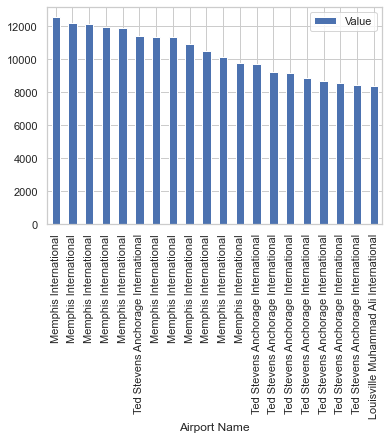

In [418]:
topTwenty[['Airport Name', 'Value']].plot(x="Airport Name", y="Value", kind = "bar")
plt.show()

In [420]:
airportLocs = pd.read_csv('us-airports.csv')
airportLocs

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,3632,KLAX,large_airport,Los Angeles International Airport,33.942501,-118.407997,125.0,NaN,United States,US,...,Los Angeles,1,KLAX,LAX,LAX,https://www.flylax.com/,https://en.wikipedia.org/wiki/Los_Angeles_Inte...,NaN,1335475,2020-04-26T22:37:22+00:00
1,3754,KORD,large_airport,Chicago O'Hare International Airport,41.978600,-87.904800,672.0,NaN,United States,US,...,Chicago,1,KORD,ORD,ORD,https://www.flychicago.com/ohare/home/pages/de...,https://en.wikipedia.org/wiki/O'Hare_Internati...,"CHI, Orchard Place",1503175,2018-09-16T02:35:35+00:00
2,3622,KJFK,large_airport,John F Kennedy International Airport,40.639801,-73.778900,13.0,NaN,United States,US,...,New York,1,KJFK,JFK,JFK,https://www.jfkairport.com/,https://en.wikipedia.org/wiki/John_F._Kennedy_...,"Manhattan, New York City, NYC, Idlewild, IDL, ...",1052075,2021-11-21T19:43:08+00:00
3,3384,KATL,large_airport,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101,1026.0,NaN,United States,US,...,Atlanta,1,KATL,ATL,ATL,http://www.atlanta-airport.com/,https://en.wikipedia.org/wiki/Hartsfield–Jacks...,NaN,2002475,2018-09-19T14:50:01+00:00
4,3878,KSFO,large_airport,San Francisco International Airport,37.618999,-122.375000,13.0,NaN,United States,US,...,San Francisco,1,KSFO,SFO,SFO,http://www.flysfo.com/,https://en.wikipedia.org/wiki/San_Francisco_In...,"QSF, QBA",1112475,2008-06-13T14:30:04+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29158,353111,US-6578,closed,Kettenpom Airport,40.160970,-123.463850,3408.0,NaN,United States,US,...,Zenia,0,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-02-28T15:05:57+00:00
29159,322813,US-0527,heliport,AdventHealth Zephyrhills Heliport,28.261934,-82.185663,160.0,NaN,United States,US,...,Zephyrhills,0,FD75,NaN,FD75,NaN,NaN,Florida Hospital Zephyrhills Heliport,0,2021-06-11T17:55:06+00:00
29160,324916,US-0652,heliport,Rotary Run Heliport,40.605805,-81.415002,1027.0,NaN,United States,US,...,Zoar,0,NaN,NaN,0OH2,NaN,NaN,NaN,0,2017-09-09T20:04:27+00:00
29161,327838,US-0874,heliport,Black Rock Heliport,35.084975,-108.788350,6454.0,NaN,United States,US,...,Zuni,0,NaN,NaN,NM1,NaN,NaN,NaN,0,2018-05-15T23:12:01+00:00


In [426]:
newdf = airportLocs.head(100)

fig = px.scatter_geo(newdf,lat='latitude_deg',lon='longitude_deg', hover_name="name")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

In [428]:
airportLocs.loc[airportLocs['iata_code'] == 'LAX', 'latitude_deg']
airportLocs.loc[airportLocs['iata_code'] == 'LAX', 'longitude_deg']

0   -118.407997
Name: longitude_deg, dtype: float64

In [520]:
def addLatLng(row):
    mylat = airportLocs.loc[airportLocs['iata_code'] == row['Airport ID'], 'latitude_deg'].to_string(index=False)
    mylng = airportLocs.loc[airportLocs['iata_code'] == row['Airport ID'], 'longitude_deg'].to_string(index=False)
    
    mylat = re.sub(r'(\w+)(?=.*:)', 'http', mylat)
    mylng = re.sub(r'(\w+)(?=.*:)', 'http', mylng)
    row['Lat'] = mylat
    row['Lng'] = mylng
    return row

adf = adf.apply(addLatLng, axis=1)

In [521]:
adf

,Airport Name,Year,City,Airport ID,Value,Lat,Lng
0,Memphis International,2000,Memphis,MEM,6318.0,35.0424,-89.9767
1,Ted Stevens Anchorage International,2000,Anchorage,ANC,8084.0,61.1744,-149.996002
2,Louisville Muhammad Ali International,2000,Louisville,SDF,3987.0,38.1744,-85.736
3,Miami International,2000,Miami,MIA,2929.0,25.7932,-80.290604
4,Los Angeles International,2000,Los Angeles,LAX,2892.0,33.942501,-118.407997
...,...,...,...,...,...,...,...
1581,William P Hobby,2020,Houston,HOU,0.0,29.645399,-95.2789
1582,Ellington,2020,Houston,EFD,0.0,29.6073,-95.158798
1583,Lakeland Linder International,2020,Lakeland,LAL,102.0,27.988899,-82.018602
1584,Rochester International,2020,Rochester,RST,35.0,43.908298,-92.5


In [522]:
adf2 = adf.groupby(['Airport ID','Year'], as_index=False)['Value'].sum()

In [523]:
adf2

,Airport ID,Year,Value
0,ABE,2015,83.0
1,ABE,2016,194.0
2,ABE,2017,345.0
3,ABE,2018,340.0
4,ABE,2019,323.0
...,...,...,...
1581,YIP,2016,87.0
1582,YIP,2017,91.0
1583,YIP,2018,109.0
1584,YIP,2019,88.0


In [524]:
adfSum = adf.groupby(['Airport ID', 'Airport Name'], as_index=False)['Value'].sum()

In [525]:
topFifty = adfSum.sort_values(by=['Value'], ascending=False).head(50)
topFifty

,Airport ID,Airport Name,Value
85,MEM,Memphis International,131281.0
5,ANC,Ted Stevens Anchorage International,106363.0
123,SDF,Louisville Muhammad Ali International,74394.0
88,MIA,Miami International,45822.0
98,ORD,Chicago O'Hare International,41133.0
74,LAX,Los Angeles International,37574.0
64,IND,Indianapolis International,31446.0
31,CVG,Cincinnati/Northern Kentucky International,26903.0
34,DFW,Dallas-Fort Worth International,21836.0
69,JFK,John F Kennedy International,21387.0


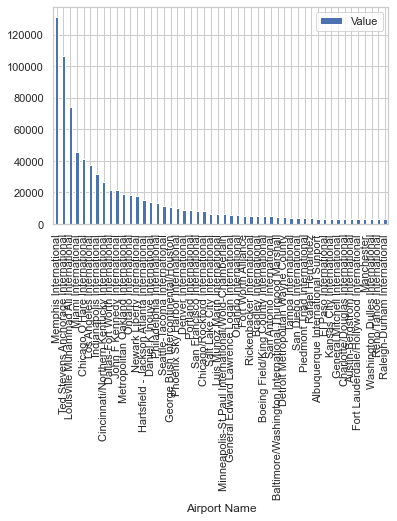

In [526]:
topFifty[['Airport Name', 'Value']].plot(x="Airport Name", y="Value", kind = "bar")
plt.show()

In [527]:
topFifty = topFifty.apply(addLatLng, axis=1)

In [528]:
topFifty

,Airport ID,Airport Name,Value,Lat,Lng
85,MEM,Memphis International,131281.0,35.0424,-89.9767
5,ANC,Ted Stevens Anchorage International,106363.0,61.1744,-149.996002
123,SDF,Louisville Muhammad Ali International,74394.0,38.1744,-85.736
88,MIA,Miami International,45822.0,25.7932,-80.290604
98,ORD,Chicago O'Hare International,41133.0,41.9786,-87.9048
74,LAX,Los Angeles International,37574.0,33.942501,-118.407997
64,IND,Indianapolis International,31446.0,39.7173,-86.294403
31,CVG,Cincinnati/Northern Kentucky International,26903.0,39.048801,-84.667801
34,DFW,Dallas-Fort Worth International,21836.0,32.896801,-97.038002
69,JFK,John F Kennedy International,21387.0,40.639801,-73.7789


In [529]:
fig = px.scatter_geo(topFifty,lat='Lat',lon='Lng', hover_name="Airport Name", size="Value")
fig.update_layout(title = 'Top Airports for Freight', title_x=0.5, geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True
        ))

fig.show()

In [537]:
# we need a slider for years
# df containing top 20 for each year

adf['Year'].unique()

array([2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

In [538]:
adfYear2000 = adf.loc[adf['Year'] == 2000]
adfYear2010 = adf.loc[adf['Year'] == 2010]
adfYear2011 = adf.loc[adf['Year'] == 2011]
adfYear2012 = adf.loc[adf['Year'] == 2012]
adfYear2013 = adf.loc[adf['Year'] == 2013]
adfYear2014 = adf.loc[adf['Year'] == 2014]
adfYear2015 = adf.loc[adf['Year'] == 2015]
adfYear2016 = adf.loc[adf['Year'] == 2016]
adfYear2017 = adf.loc[adf['Year'] == 2017]
adfYear2018 = adf.loc[adf['Year'] == 2018]
adfYear2019 = adf.loc[adf['Year'] == 2019]
adfYear2020 = adf.loc[adf['Year'] == 2020]

In [546]:
getTopNum = 50
allFrames = [adfYear2000.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2010.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2011.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2012.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2013.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2014.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2015.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2016.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2017.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2018.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2019.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2020.sort_values(by=['Value'], ascending=False).head(getTopNum)]
topCargoAirports = pd.concat(allFrames)

In [547]:
topCargoAirports

,Airport Name,Year,City,Airport ID,Value,Lat,Lng
1,Ted Stevens Anchorage International,2000,Anchorage,ANC,8084.0,61.1744,-149.996002
0,Memphis International,2000,Memphis,MEM,6318.0,35.0424,-89.9767
2,Louisville Muhammad Ali International,2000,Louisville,SDF,3987.0,38.1744,-85.736
3,Miami International,2000,Miami,MIA,2929.0,25.7932,-80.290604
4,Los Angeles International,2000,Los Angeles,LAX,2892.0,33.942501,-118.407997
...,...,...,...,...,...,...,...
1487,Albuquerque International Sunport,2020,Albuquerque,ABQ,304.0,35.040199,-106.609001
1488,Sacramento Mather,2020,Sacramento,MHR,299.0,38.553902,-121.297997
1483,General Mitchell International,2020,Milwaukee,MKE,298.0,42.947201,-87.896599
1485,Kansas City International,2020,Kansas City,MCI,298.0,39.2976,-94.713898


In [596]:
fig = px.scatter_geo(topCargoAirports,lat='Lat',lon='Lng', hover_name="Airport Name", size="Value",
                     animation_frame="Year", animation_group="Airport Name")
fig.update_layout(title = 'Top Airports for Freight', title_x=0.5, geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True
        ))

fig.show()